In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('ames_model.csv')
df.set_index('id', verify_integrity=True, inplace=True)

In [4]:
df.head()

,ms_subclass,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,1st_flr_sf,low_qual_fin_sf,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice,ms_zoning_C,ms_zoning_FV,ms_zoning_I,ms_zoning_RH,ms_zoning_RL,ms_zoning_RM,ms_zoning_nan,street_Pave,street_nan,alley_Pave,alley_nan,lot_shape_IR2,lot_shape_IR3,lot_shape_Reg,lot_shape_nan,land_contour_HLS,land_contour_Low,land_contour_Lvl,land_contour_nan,utilities_NoSeWa,utilities_NoSewr,utilities_nan,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,lot_config_nan,land_slope_Mod,land_slope_Sev,land_slope_nan,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,neighborhood_nan,condition_1_Feedr,condition_1_Norm,condition_1_PosA,condition_1_PosN,condition_1_RRAe,condition_1_RRAn,condition_1_RRNe,condition_1_RRNn,condition_1_nan,condition_2_Feedr,condition_2_Norm,condition_2_PosA,condition_2_PosN,condition_2_RRAe,condition_2_RRAn,condition_2_RRNn,condition_2_nan,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,bldg_type_nan,house_style_1.5Unf,house_style_1Story,house_style_2.5Fin,house_style_2.5Unf,house_style_2Story,house_style_SFoyer,house_style_SLvl,house_style_nan,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,roof_style_Mansard,roof_style_Shed,roof_style_nan,roof_matl_CompShg,roof_matl_Membran,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl,roof_matl_nan,exterior_1st_AsphShn,exterior_1st_BrkComm,exterior_1st_BrkFace,exterior_1st_CBlock,exterior_1st_CemntBd,exterior_1st_HdBoard,exterior_1st_ImStucc,exterior_1st_MetalSd,exterior_1st_Plywood,exterior_1st_Stone,exterior_1st_Stucco,exterior_1st_VinylSd,exterior_1st_Wd Sdng,exterior_1st_WdShing,exterior_1st_nan,exterior_2nd_AsphShn,exterior_2nd_Brk Cmn,exterior_2nd_BrkFace,exterior_2nd_CBlock,exterior_2nd_CmentBd,exterior_2nd_HdBoard,exterior_2nd_ImStucc,exterior_2nd_MetalSd,exterior_2nd_Plywood,exterior_2nd_Stone,exterior_2nd_Stucco,exterior_2nd_VinylSd,exterior_2nd_Wd Sdng,exterior_2nd_Wd Shng,exterior_2nd_nan,mas_vnr_type_BrkFace,mas_vnr_type_None,mas_vnr_type_Stone,mas_vnr_type_nan,exter_qual_Fa,exter_qual_Gd,exter_qual_TA,exter_qual_nan,exter_cond_Fa,exter_cond_Gd,exter_cond_Po,exter_cond_TA,exter_cond_nan,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,foundation_nan,bsmt_qual_Fa,bsmt_qual_Gd,bsmt_qual_Po,bsmt_qual_TA,bsmt_qual_nan,bsmt_cond_Fa,bsmt_cond_Gd,bsmt_cond_Po,bsmt_cond_TA,bsmt_cond_nan,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,bsmt_exposure_nan,bsmtfin_type_1_BLQ,bsmtfin_type_1_GLQ,bsmtfin_type_1_LwQ,bsmtfin_type_1_Rec,bsmtfin_type_1_Unf,bsmtfin_type_1_nan,bsmtfin_type_2_BLQ,bsmtfin_type_2_GLQ,bsmtfin_type_2_LwQ,bsmtfin_type_2_Rec,bsmtfin_type_2_Unf,bsmtfin_type_2_nan,heating_GasW,heating_Grav,heating_OthW,heating_Wall,heating_nan,heating_qc_Fa,heating_qc_Gd,heating_qc_Po,heating_qc_TA,heating_qc_nan,central_air_Y,central_air_nan,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,electrical_nan,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_TA,kitchen_qual_nan,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sal,functional_Sev,functional_Typ,functional_nan,fireplace_qu_Fa,fireplace_qu_Gd,fireplace_qu_Po,fireplace_qu_TA,fireplace_qu_nan,garage_type_Attchd,garage_type_Ba

In [5]:
features = [col for col in df.columns if col != 'saleprice']

X = df[features]
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

## Statsmodels OLS  
### Start with an unregularized linear regression

In [6]:
# # manually add the intercept column:
X_train_c = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_c)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     71.25
Date:                Wed, 22 Aug 2018   Prob (F-statistic):               0.00
Time:                        12:25:04   Log-Likelihood:                -15493.
No. Observations:                1374   AIC:                         3.148e+04
Df Residuals:                    1128   BIC:                         3.276e+04
Df Model:                         245                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -8.875e+05   8.33e+05     -1.066      0.287   -2.52e+06    7.47e+05
ms_subclass            -43.2222     81.540     -0.530      0.596    -203.210     116.766
lot_area                 0.7840      0.138      5.691      0.000       0.514       1.054
overall_qual          6649.1076    979.271      6.790      0.000    4727.710    8570.505
overall_cond          5499.1991    837.148      6.569      0.000    3856.657    7141.741
year_built             276.1139     70.916      3.894      0.000     136.972     415.255
year_remod/add          14.3923     54.720      0.263      0.793     -92.972     121.757
mas_vnr_area            24.6397      5.876      4.193      0.000      13.111      36.169
bsmtfin_sf_1            34.0929      4.598      7.414      0.000      25.070      43.115
bsmtfin_sf_2            40.2683      8.237      4.889      0.000      24.107      56.430
bsmt_unf_sf             18.2375      4.146      4.399      0.000      10.103      26.371
1st_flr_sf              35.6019      4.723      7.539      0.000      26.336      44.868
low_qual_fin_sf        -20.7881     12.857     -1.617      0.106     -46.014       4.437
bsmt_full_bath        4019.5635   1887.047      2.130      0.033     317.047    7722.080
bsmt_half_bath         -68.5410   2713.887     -0.025      0.980   -5393.375    5256.294
full_bath             8916.9165   1959.312      4.551      0.000    5072.610    1.28e+04
half_bath             7406.6755   1916.572      3.865      0.000    3646.228    1.12e+04
bedroom_abvgr         -842.7950   1240.950     -0.679      0.497   -3277.624    1592.034
kitchen_abvgr        -1.152e+04   6208.726     -1.855      0.064   -2.37e+04     662.365
totrms_abvgrd         3233.9447    856.949      3.774      0.000    1552.552    4915.337
fireplaces            8072.1492   2648.205      3.048      0.002    2876.187    1.33e+04
garage_area             36.3955      5.237      6.950      0.000      26.120      46.671
wood_deck_sf            13.1374      5.505      2.386      0.017       2.336      23.939
open_porch_sf           22.7280     11.242      2.022      0.043       0.670      44.786
enclosed_porch          20.1164     12.304      1.635      0.102      -4.024      44.257
3ssn_porch              12.8531     21.705      0.592      0.554     -29.733      55.439
screen_porch            73.0056     12.151      6.008      0.000      49.164      96.847
pool_area              566.6386    214.317      2.644      0.008     146.133     987.144
misc_val                 3.9905      4.188      0.953      0.341      -4.226      12.207
mo_sold                 -5.8241    233.004     -0.025      0.980    -462.994     451.346
yr_sold               -450.0957    508.771     -0.885      0.377   -1448.339     548.147
ms_zoning_C           1777.1180   4.87e+04      0.037    

In [7]:
X_test_c = sm.add_constant(X_test)
ols_y_hat = model.predict(X_test_c)

In [8]:
np.sqrt(mean_squared_error(y_test, ols_y_hat))

25695.58055107852

In [9]:
r2_score(y_test, ols_y_hat)

0.9033196925176232

The statsmodels OLS $R^2$ score is high.  
There is no cross validation utility to determine if the model is overfit.

## Lasso vs Recursive Feature Eleimination

## First Lasso

In [10]:
features = [col for col in df.columns if col != 'saleprice']

X = df[features]
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

In [11]:
ss = StandardScaler()
lasso = Lasso(random_state=23)
pipe = Pipeline([
    ('ss', ss),
    ('lasso', lasso)
])

parameters = {
    'lasso__alpha': np.arange(1,20,1)    
}

In [12]:

gs = GridSearchCV(pipe, param_grid=parameters, n_jobs=6, scoring='r2')
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)



0.6431727709911047
{'lasso__alpha': 19}


In [13]:
gs.grid_scores_

[mean: 0.59397, std: 0.19652, params: {'lasso__alpha': 1},
 mean: 0.60603, std: 0.19392, params: {'lasso__alpha': 2},
 mean: 0.60977, std: 0.19348, params: {'lasso__alpha': 3},
 mean: 0.61258, std: 0.19304, params: {'lasso__alpha': 4},
 mean: 0.61524, std: 0.19249, params: {'lasso__alpha': 5},
 mean: 0.61780, std: 0.19174, params: {'lasso__alpha': 6},
 mean: 0.62022, std: 0.19079, params: {'lasso__alpha': 7},
 mean: 0.62250, std: 0.18968, params: {'lasso__alpha': 8},
 mean: 0.62433, std: 0.18803, params: {'lasso__alpha': 9},
 mean: 0.62606, std: 0.18634, params: {'lasso__alpha': 10},
 mean: 0.62777, std: 0.18467, params: {'lasso__alpha': 11},
 mean: 0.62957, std: 0.18308, params: {'lasso__alpha': 12},
 mean: 0.63147, std: 0.18153, params: {'lasso__alpha': 13},
 mean: 0.63342, std: 0.17991, params: {'lasso__alpha': 14},
 mean: 0.63530, std: 0.17832, params: {'lasso__alpha': 15},
 mean: 0.63712, std: 0.17679, params: {'lasso__alpha': 16},
 mean: 0.63913, std: 0.17522, params: {'lasso__al

In [14]:
np.sqrt(mean_squared_error(y_test, gs.predict(X_test)))

25907.109587010265

In [15]:
r2_score(y_test, gs.predict(X_test))

0.9017213734258029

In [16]:
llr = Lasso(alpha=gs.best_params_['lasso__alpha'], random_state=23)
llr.fit(X_train, y_train)

y_hat = llr.predict(X_test)

In [17]:
np.sqrt(mean_squared_error(y_test, y_hat))

28623.327734979775

## Using Automatic Feature Selection

In [18]:
features = [col for col in df.columns if col != 'saleprice']

X = df[features]
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

### Feature ranking with recursive feature elimination.

In [19]:
lr = LinearRegression()
select = RFECV(estimator=lr, step=1, scoring='r2', n_jobs=6)

In [20]:
select = select.fit(X_train, y_train)

In [21]:
select.n_features_

45

In [22]:
select.score(X_train, y_train)

0.7525904536588617

In [23]:
y_sel_hat = select.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_sel_hat))

42834.5979098847

In [24]:
select.score(X_test, y_test)

0.7313353399965576

## Using Principal Component Analysis for dimensionality reduction.

In [25]:
features = [col for col in df.columns if col != 'saleprice']

X = df[features]
y = df['saleprice']

In [26]:
pca = PCA()
pca.fit(X)
np.set_printoptions(suppress=True)

In [27]:
pca.components_[0][:10]

array([-0.00156006,  0.99954656,  0.00002261, -0.00000319,  0.00016502,
        0.00016027,  0.00435458,  0.01485176,  0.00102286,  0.00274771])

In [28]:
pca.explained_variance_ratio_[:30]

array([0.97858543, 0.00748914, 0.00618572, 0.00458403, 0.0009507 ,
       0.00074156, 0.00046724, 0.00033013, 0.00028406, 0.00008951,
       0.00007643, 0.00006716, 0.00005374, 0.00003469, 0.00002911,
       0.00001361, 0.00001293, 0.00000433, 0.00000016, 0.00000005,
       0.00000004, 0.00000002, 0.00000002, 0.00000001, 0.00000001,
       0.00000001, 0.00000001, 0.00000001, 0.00000001, 0.00000001])

Cumulative explained variance:  0.9999395197676857


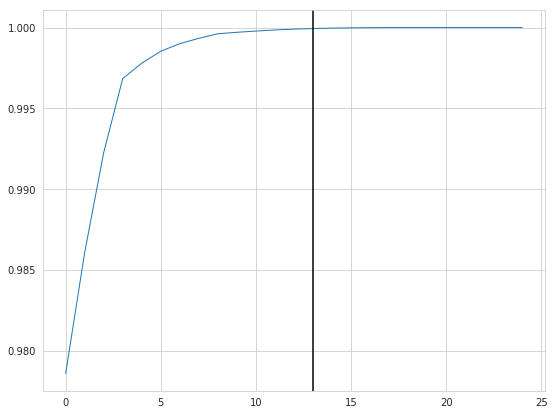

In [29]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative explained variance: ', cum_var_exp[13])

sns.set_style(style='whitegrid')
plt.figure(figsize=(9,7))

# Plot the cumulative explained variance
component_number = range(len(cum_var_exp[:25]))
plt.plot(component_number, cum_var_exp[:25], lw=1)
plt.axvline(x=13, color='k')
plt.show()

##### It can be seen that the first principal component captures over 97% of the explained variance.  
##### The first 13 principal components capture 99.99% of the vaiance, of the original 283 components.

In [30]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

# This is an expensive operation but illustrates the point.
mean_cross_val_score0 = []
for i in np.arange(1,150,5):
    pc = PCA(n_components=i, random_state=0)
    Z = pc.fit_transform(Xs)

    pclr = LinearRegression()
    fold = 5
    mean_cross_val_score0.append(
        cross_val_score(pclr, Z, y, cv=fold, verbose=0, n_jobs=fold).mean()
    )

mean_cross_val_score1 = []
for i in np.arange(1,150,5):
    pc = PCA(n_components=i, random_state=100)
    Z = pc.fit_transform(Xs)

    pclr = LinearRegression()
    fold = 5
    mean_cross_val_score1.append(
        cross_val_score(pclr, Z, y, cv=fold, verbose=0, n_jobs=fold).mean()
    )
    
mean_cross_val_score2 = []
for i in np.arange(1,150,5):
    pc = PCA(n_components=i, random_state=200)
    Z = pc.fit_transform(Xs)

    pclr = LinearRegression()
    fold = 5
    mean_cross_val_score2.append(
        cross_val_score(pclr, Z, y, cv=fold, verbose=0, n_jobs=fold).mean()
    )
    
mean_cross_val_score3 = []
for i in np.arange(1,150,5):
    pc = PCA(n_components=i, random_state=300)
    Z = pc.fit_transform(Xs)

    pclr = LinearRegression()
    fold = 5
    mean_cross_val_score3.append(
        cross_val_score(pclr, Z, y, cv=fold, verbose=0, n_jobs=fold).mean()
    )
    
mean_cross_val_score4 = []
for i in np.arange(1,150,5):
    pc = PCA(n_components=i, random_state=400)
    Z = pc.fit_transform(Xs)

    pclr = LinearRegression()
    fold = 5
    mean_cross_val_score4.append(
        cross_val_score(pclr, Z, y, cv=fold, verbose=0, n_jobs=fold).mean()
    )

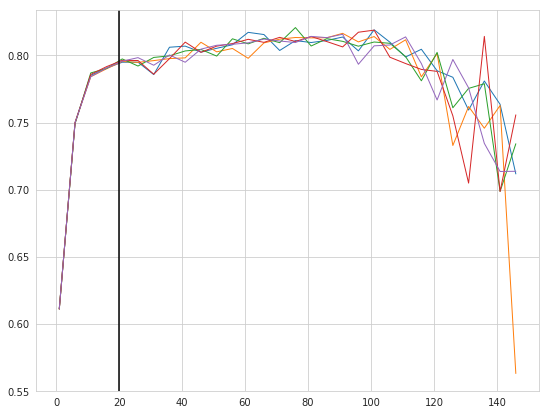

In [31]:
plt.figure(figsize=(9,7))

# Plot the mean cross validation score for each number of pc's
component_number = np.arange(1,150,5)
plt.plot(component_number, mean_cross_val_score0, lw=1)
plt.plot(component_number, mean_cross_val_score1, lw=1)
plt.plot(component_number, mean_cross_val_score2, lw=1)
plt.plot(component_number, mean_cross_val_score3, lw=1)
plt.plot(component_number, mean_cross_val_score4, lw=1)
plt.axvline(x=20, color='k')
plt.show()

An $R^2$ score of 0.80 is nearly achieved with approximately 20 principal components.  
It can be seen that at 20 pc's there is very little variance in the mean cross validation score.  
Chose the first 20 principal components to capture most of the explained variance  
with minimal chances of overfitting.

In [32]:
pca_reg = LinearRegression()
pca = PCA(n_components=20)
Z = pca.fit_transform(Xs)

cross_val_score(pca_reg, Z, y, cv=3, verbose=0, n_jobs=3)

array([0.8131497 , 0.78506808, 0.78824855])

In [33]:
y_pc_hat = cross_val_predict(pclr, Z, y, cv=3, verbose=0, n_jobs=3)

In [34]:
np.sqrt(mean_squared_error(y, y_pc_hat))

35823.68316938206